### Tidy the GEFCom2012 dataset
From 3 file, load_raw.csv, n034_ensemble.csv and temp.csv create the complete.csv file. Use value from ensemble prediction to impute missing value in load_raw, and add temperature values from temp.csv to the final complete dataframe.

#### Read data from csv file

In [1]:
library(tidyr)
library(dplyr)
library(lubridate)

loadRawFile = "GEFCom2012/load_raw.csv"
tempRawFile = "GEFCom2012/temp.csv"
ensemblePredictionFile = "GEFCom2012/n034_ensemble.csv"

#Define a class num.with.commas to probably transform string with comma to number
setClass("num.with.commas")
setAs("character", "num.with.commas", 
        function(from) as.numeric(gsub(",", "", from) ) )

loadRawClasses = c('factor', rep("numeric", 3), rep("num.with.commas", 24))

df = read.csv(loadRawFile, stringsAsFactors=FALSE, colClasses=loadRawClasses)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



#### Tidy loadraw GEFCom2012 data

In [2]:
tidyLoadDf = df %>%  gather(Hour, Consumption, h1:h24) %>%
                 mutate(Hour=as.numeric(substr(Hour, 2, nchar(Hour)))-1) %>%
                 unite(Date, year, month, day, sep='-') %>%
                 unite(DateTime, Date, Hour, sep=' ') %>%
                 mutate(DateTime=as.POSIXct(strptime(DateTime, "%Y-%m-%d %H", tz = "GMT"))) %>%
                 arrange(DateTime, zone_id)


In [3]:
#Spead consumption for each zone into seperate columns, so that we can easily select consumption for each zone later
tidyLoadDf = tidyLoadDf %>% mutate(zone_id=paste0('zone.',as.character(zone_id))) %>%
                      spread(zone_id, Consumption, fill = NA, convert = FALSE)
#Remove 2008/June data, because it's not complete, Create Zone 21 as sum of 20 zones consumption
tidyLoadDf = tidyLoadDf %>% filter(DateTime<as.POSIXct(strptime("2008-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")))
#Add total consumption collumn
tidyLoadDf %>% select(zone.1:zone.20) %>% rowSums(na.rm=TRUE) -> tidyLoadDf$total

#### Tidy ensemble prediction GEFCom2012 data

In [5]:
ensembleClasses = c('NULL', 'factor', rep("numeric", 27))
df = read.csv(ensemblePredictionFile, stringsAsFactors=FALSE, colClasses=ensembleClasses)
tidyEnsembleDf = df %>%  gather(Hour, Consumption, h1:h24) %>%
                 mutate(Hour=as.numeric(substr(Hour, 2, nchar(Hour)))-1) %>%
                 unite(Date, year, month, day, sep='-') %>%
                 unite(DateTime, Date, Hour, sep=' ') %>%
                 mutate(DateTime=as.POSIXct(strptime(DateTime, "%Y-%m-%d %H", tz = "GMT"))) %>%
                 arrange(DateTime) %>%
                 mutate(zone_id=paste0('zone.',as.character(zone_id))) %>%
                 spread(zone_id, Consumption, fill = NA, convert = FALSE) %>% #Remove forecast, only need backcast
                 filter(DateTime<as.POSIXct(strptime("2008-06-01 00:00:00", "%Y-%m-%d %H:%M:%S"))) 

#### Merge ensemble prediction to raw load data, and add temperature data

In [6]:
fullDf = tidyLoadDf
fullDf[is.na(fullDf$zone.1), ] = tidyEnsembleDf

In [13]:
tempClasses = c('POSIXct', rep("numeric", 11))
tempDf = read.csv(tempRawFile, stringsAsFactors=FALSE, colClasses=tempClasses)
tempDf = tempDf %>% mutate(DateTime = DateTime - minutes(30))
df = left_join(fullDf, tempDf, by="DateTime")

In [23]:
complete.cases(df)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
   [15] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
   [29] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
   [43] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
   [57] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
   [71] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
   [85] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
   [99] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [113] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [127] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [141] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [155] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [169] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [183] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [197] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [225] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [239] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [253] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [267] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [281] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [295] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [309] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [323] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [337] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [351] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [365] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [379] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [393] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [407] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [435] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [449] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [463] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [477] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [491] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [505] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [519] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [533] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [547] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [561] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [575] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [589] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [603] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [617] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [631] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [645] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [659] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [673] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [687] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [701] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [715] TRUE TRUE TRUE TRU

In [17]:
install.packages("Amelia")

also installing the dependency ‘foreign’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2016 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


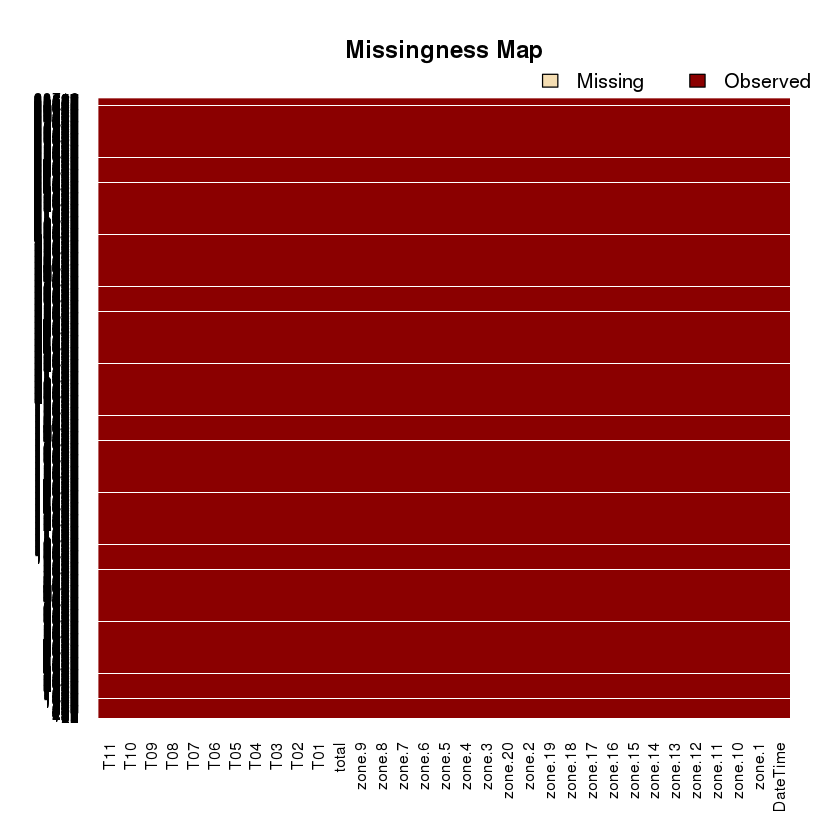

In [18]:
library("Amelia")
missmap(df)

In [22]:
#library(rminer)
library(forecast)
#library(KernSmooth)
library(timeDate)
library(MASS)
library(mgcv)
#library(bbemkr)